In [38]:
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.linalg import orthogonal_procrustes
from scipy.stats import ortho_group

In [39]:
rng = np.random.default_rng(1234)
N = 1000
D = 10
n_repetitions = 10
n_permutations = 10

results = {"D": [], "dist": [], "value": [], "noise": []}

# for i in [1, 5, 10, 20, 30, 100]:
for i in [1, 5, 10, 20, 30]:
    increased_D = i * D
    for noise_level in [1e-2, 1e-1, 1e-0]:
        for repetition in range(n_repetitions):
            # One random matrix and one rotated version with added noise
            Q = ortho_group.rvs(increased_D, size=1)
            a = rng.standard_normal((N, increased_D))
            b = a @ Q + noise_level * rng.standard_normal((N, increased_D))

            r, scale = orthogonal_procrustes(a, b)
            total_norm = (
                -2 * scale
                + np.linalg.norm(a, ord="fro") ** 2
                + np.linalg.norm(b, ord="fro") ** 2
            )
            
            results["D"].append(increased_D)
            results["dist"].append("ortho_proc")
            results["value"].append(np.sqrt(total_norm))
            results["noise"].append(noise_level)
            
            results["D"].append(increased_D)
            results["dist"].append("squared_ortho_proc")
            results["value"].append(total_norm)
            results["noise"].append(noise_level)
            
            # baseline value for unrelated matrices
            for _ in range(n_permutations):
                a_shuffled = rng.permutation(a, axis=0)
                shuffled_norm = (
                    -2 * orthogonal_procrustes(a_shuffled, b)[1]
                    + np.linalg.norm(a_shuffled, ord="fro") ** 2
                    + np.linalg.norm(b, ord="fro") ** 2
                )
                results["D"].append(increased_D)
                results["dist"].append("shuffled")
                results["value"].append(np.sqrt(shuffled_norm))
                results["noise"].append(noise_level)
                
                results["D"].append(increased_D)
                results["dist"].append("squared_shuffled")
                results["value"].append(shuffled_norm)
                results["noise"].append(noise_level)
    
df = pd.DataFrame.from_dict(results)


In [37]:
# df.to_parquet("procrustes_dim_increase.parquet")

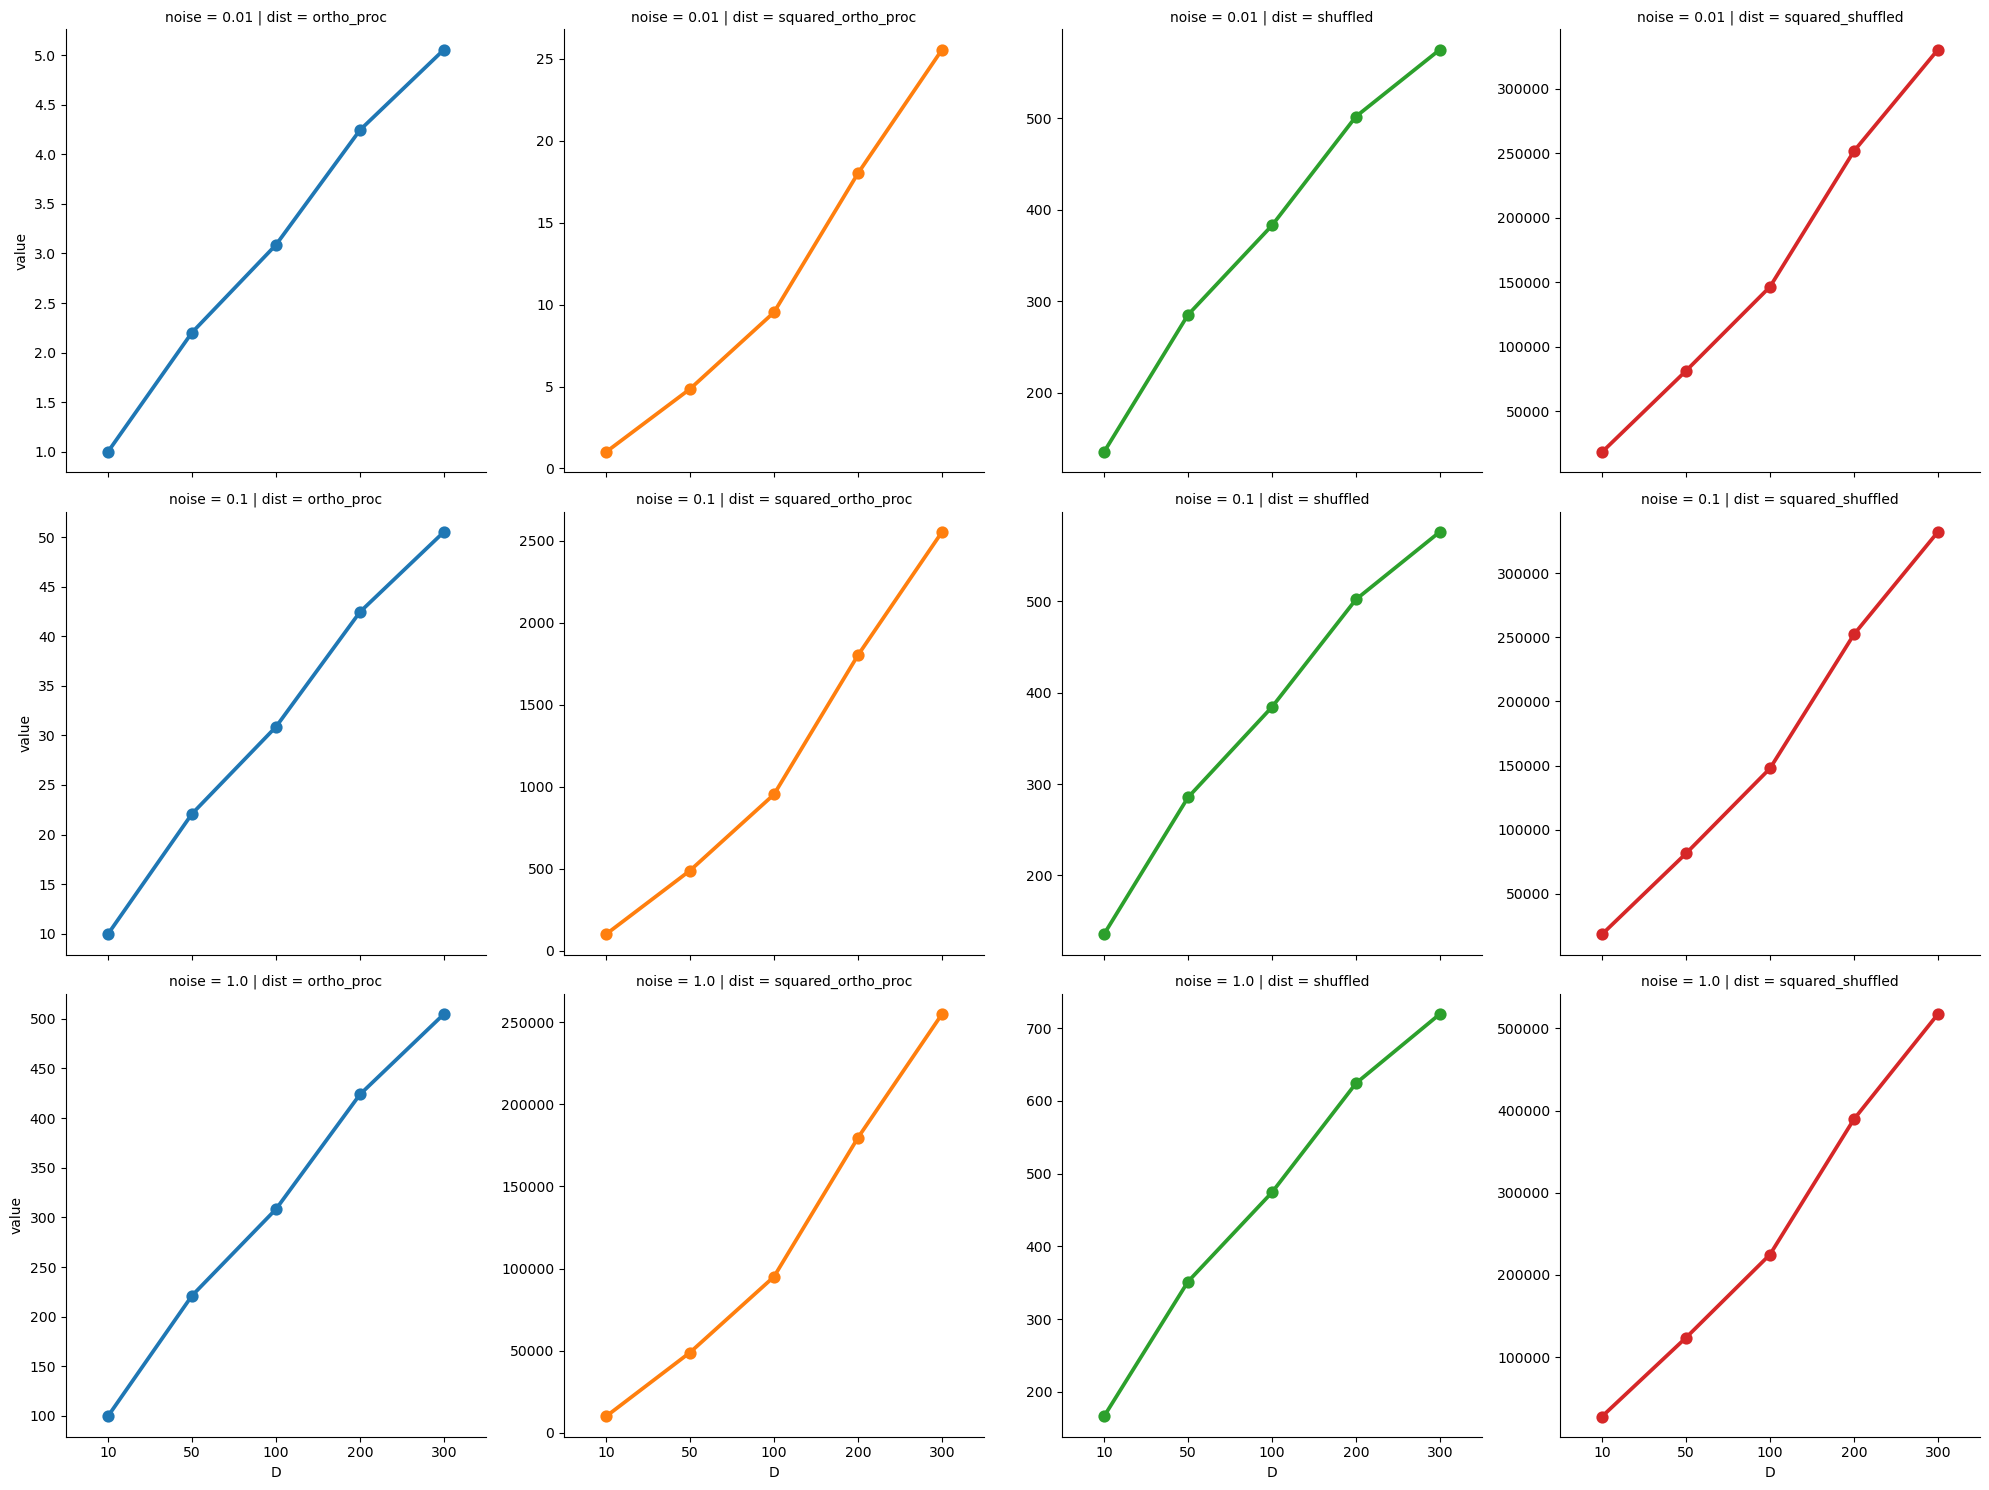

In [40]:
g = sns.catplot(
    df,
    x="D",
    y="value",
    hue="dist",
    col="dist",
    kind="point",
    row="noise",
    sharey=False,
    errorbar="se",
)

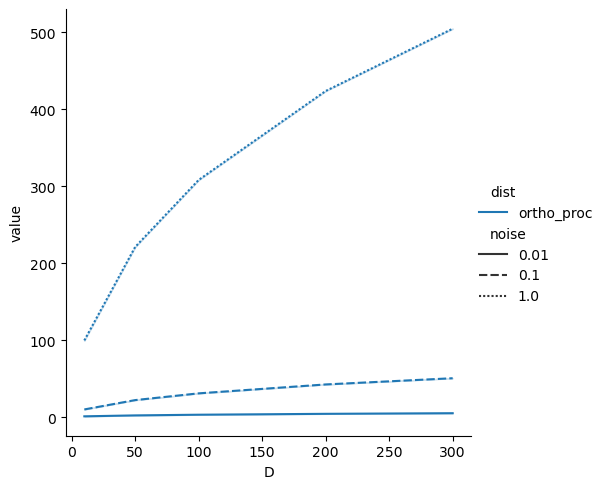

In [45]:
g = sns.relplot(
    data=df[~df["dist"].isin(["squared_shuffled", "squared_ortho_proc", "shuffled"])],
    x="D",
    y="value",
    hue="dist",
    style="noise",
    kind="line",
)
# g.set(yscale="log")